### Connect to Drive & import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive


# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.convnext import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mounted at /gdrive
/gdrive/My Drive
2.14.0


In [ ]:
!pip install -q keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 29.2 MB/s eta 0:00:00


In [ ]:
import json
import math
import keras_cv

Using TensorFlow backend


mixed precision used to speed up the training

In [ ]:
 tf.keras.mixed_precision.set_global_policy("mixed_float16")



### Load data

Used an already cleaned dataset to speed up the process

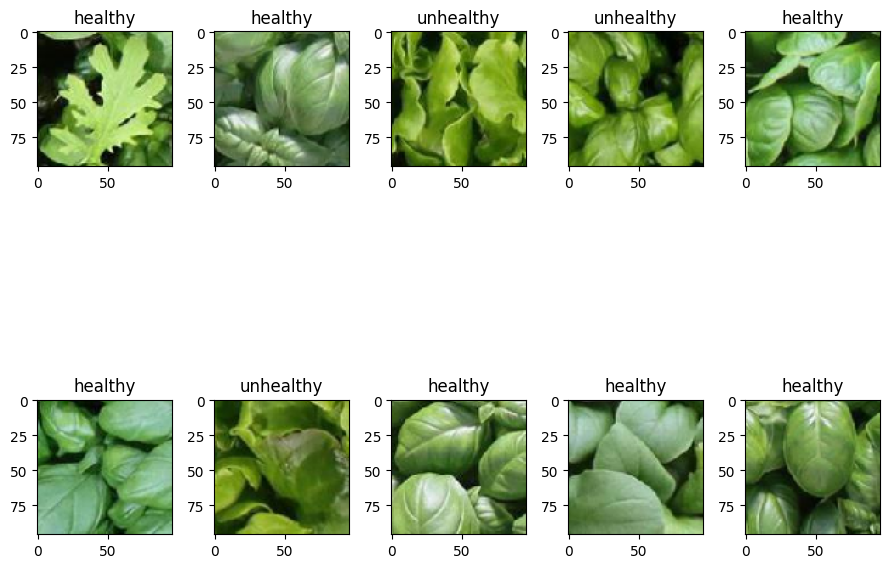

In [ ]:
dataset = np.load('public_data_cleanup_no_duplicates.npz', allow_pickle=True)

images = []

for img in dataset['data']:
  img=(img).astype(np.float32)
  images.append(img)

images=np.array(images)

# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(9, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(images[i]/255, 0, 255))  # Display clipped item images
    ax.set_title('{}'.format(dataset['labels'][i]))

plt.tight_layout()
plt.show()


### Process the dataset

In [ ]:
# Transform labels via one-hot encoding
# i.e. 'healthy' -> [1,0], 'unhealty' -> [0,1]
#create an instance of labelencoder
labelencoder = LabelEncoder()

labels = labelencoder.fit_transform(dataset['labels'])
print(labels.shape)

#OneHotEncoding
labels = tfk.utils.to_categorical(labels,2)
print(labels.shape)

print(img[1])

#example of the lables encoding
print(labels[1])
print(labels[2])
print(labels[3])
print(labels[4])
print(labels[5])


(4850,)
(4850, 2)
[[ 77. 121.  42.]
 [ 84. 131.  50.]
 [ 79. 135.  44.]
 [ 74. 135.  42.]
 [ 76. 141.  51.]
 [ 79. 147.  64.]
 [ 94. 160.  99.]
 [103. 166. 113.]
 [119. 177. 129.]
 [135. 189. 139.]
 [148. 197. 131.]
 [148. 194. 119.]
 [145. 194. 113.]
 [116. 173.  92.]
 [130. 194. 120.]
 [136. 201. 135.]
 [136. 201. 143.]
 [132. 197. 143.]
 [125. 190. 132.]
 [116. 180. 119.]
 [132. 193. 126.]
 [141. 197. 126.]
 [153. 196. 127.]
 [151. 190. 123.]
 [119. 154.  88.]
 [ 76. 112.  48.]
 [ 41.  82.  22.]
 [ 36.  80.  17.]
 [ 35.  79.  16.]
 [ 35.  81.  17.]
 [ 37.  83.  19.]
 [ 36.  82.  20.]
 [ 38.  82.  23.]
 [ 39.  79.  26.]
 [ 34.  65.  23.]
 [ 29.  55.  18.]
 [ 22.  46.  14.]
 [ 21.  40.  12.]
 [ 21.  42.  11.]
 [ 21.  42.   9.]
 [ 20.  44.   8.]
 [ 21.  45.   9.]
 [ 22.  46.  10.]
 [ 22.  48.   9.]
 [ 22.  48.   9.]
 [ 21.  47.   8.]
 [ 20.  48.   7.]
 [ 21.  49.   8.]
 [ 21.  49.   8.]
 [ 21.  49.   8.]
 [ 20.  51.   7.]
 [ 21.  52.   8.]
 [ 21.  52.   8.]
 [ 20.  51.   7.]
 [ 21.  52

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, random_state=seed, test_size=0.1, stratify=labels)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=y_train_val)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3880, 96, 96, 3), y_train shape: (3880, 2)
X_val shape: (485, 96, 96, 3), y_val shape: (485, 2)
X_test shape: (485, 96, 96, 3), y_test shape: (485, 2)


now we apply augumentation from keras cv directly on the dataset loaded

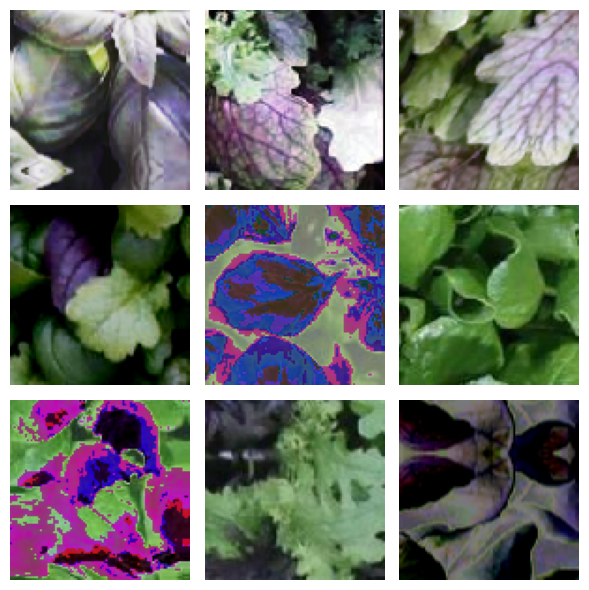

In [ ]:
augmenters = []

rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,
    magnitude=0.3,
    value_range=(0, 255),
)
augmenters += [rand_augment]


image_batch = rand_augment(X_train)
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

X_train = np.array(image_batch)

we can also add noise to the train set, to get a more solid model

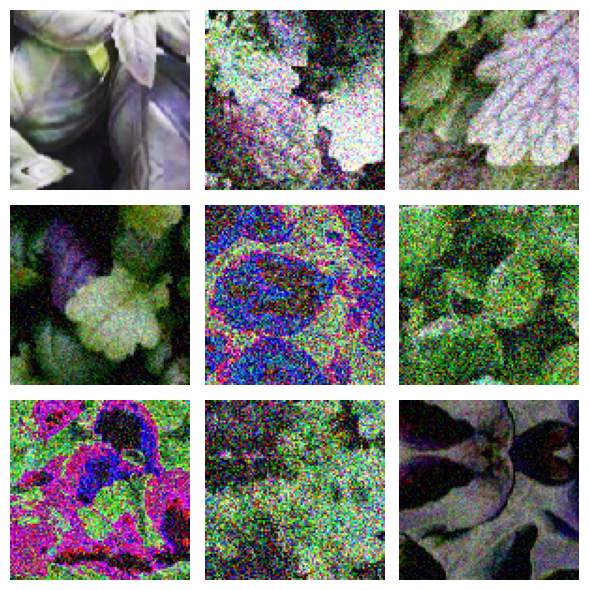

In [ ]:
# Adding noise
X_train_noise = []

for image in X_train:
    # Adding noise to the image
    VARIABILITY = 0.3
    deviation = VARIABILITY * 255 * random.random()
    noise = np.random.normal(0, deviation, image.shape)
    image += noise
    np.clip(image, 0., 255., out=image)
    X_train_noise.append(image)

X_train = np.array(X_train_noise)


keras_cv.visualization.plot_image_gallery(
    X_train,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)


at this point, having the dataset with too much healty and less unhealty, we need to balance classes.


In [ ]:
#weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
ymax = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=ymax)
print(weights)

class_weights = {0: weights[0], 1: weights[1]}

[0.79248366 1.3547486 ]


### Train convNextBase with freezed inner model

first define a data augumentation layer

In [ ]:
data_augmentation = keras.Sequential(
    [
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomTranslation(0.5, 0.5),
    ]
)

then the inner model, with specified shape and internal pooling.
freeze all the internal layers

In [ ]:
convnext = tf.keras.applications.ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    include_preprocessing=True,
    pooling="avg",
)
convnext.trainable = False

#Display the model architecture with input shapes
tfk.utils.plot_model(convnext, show_shapes=True)

In [ ]:
# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

x=data_augmentation(inputs)

x = convnext(x, training=False)

dense1 = tfkl.Dense(units=1000, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(2e-4), name='dense1')(x)

#add dropout
x = keras.layers.Dropout(0.5)(dense1)

dense2 = tfkl.Dense(units=550, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(2e-4), name='dense2')(x)

#add dropout
x = keras.layers.Dropout(0.3)(dense2)


dense3 = tfkl.Dense(units=100, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(2e-4), name='dense3')(x)

x = keras.layers.Dropout(0.2)(dense3)

# Add a Dense layer as classifier

outputs=tfkl.Dense(2, activation='sigmoid')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='convnext')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "convnext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550    
                                                                 
 dropout_4 (Dropout)         (None, 550)               0  

In [ ]:
dense1.trainable=True
dense2.trainable=True
dense3.trainable=True
outputs.trainable=True

In [ ]:
model.save("ConvNeXtBase")

Train the model

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought
    y = y_train,
    class_weight=class_weights,
    batch_size = 16,
    epochs = 400,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=35, restore_best_weights=True),
                 tf.keras.callbacks.ReduceLROnPlateau()]
).history

Epoch 1/400
243/243 [==============================] - 54s 131ms/step - loss: 1.4209 - accuracy: 0.5863 - val_loss: 1.2530 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 2/400
243/243 [==============================] - 18s 73ms/step - loss: 1.2352 - accuracy: 0.6562 - val_loss: 1.1425 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 3/400
243/243 [==============================] - 19s 77ms/step - loss: 1.1382 - accuracy: 0.6863 - val_loss: 1.0171 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 4/400
243/243 [==============================] - 18s 76ms/step - loss: 1.0512 - accuracy: 0.7082 - val_loss: 0.9713 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 5/400
243/243 [==============================] - 17s 71ms/step - loss: 0.9936 - accuracy: 0.7005 - val_loss: 0.8938 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 6/400
243/243 [==============================] - 18s 75ms/step - loss: 0.9299 - accuracy: 0.7222 - val_loss: 0.8845 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 7/400
243/243 [==============================

In [ ]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8598


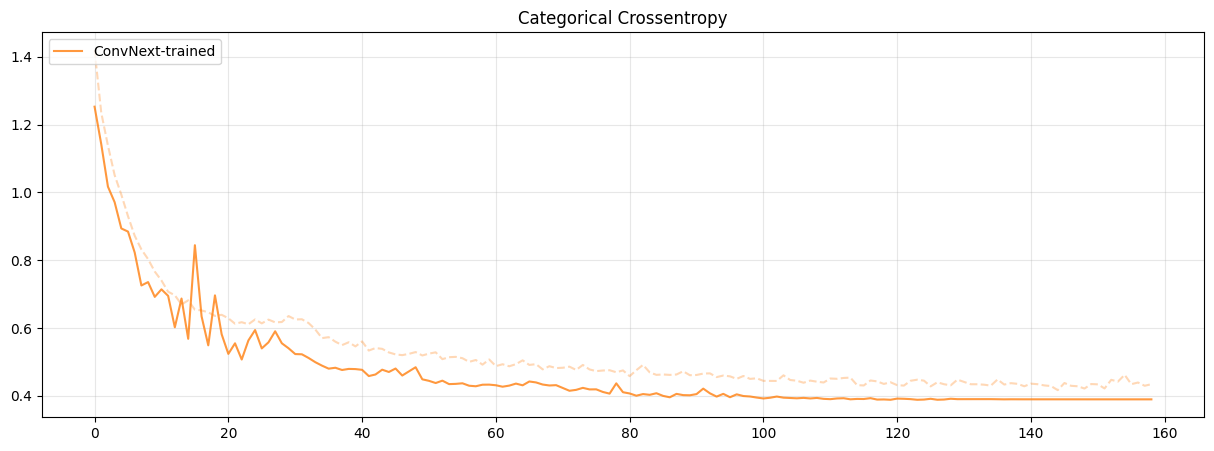

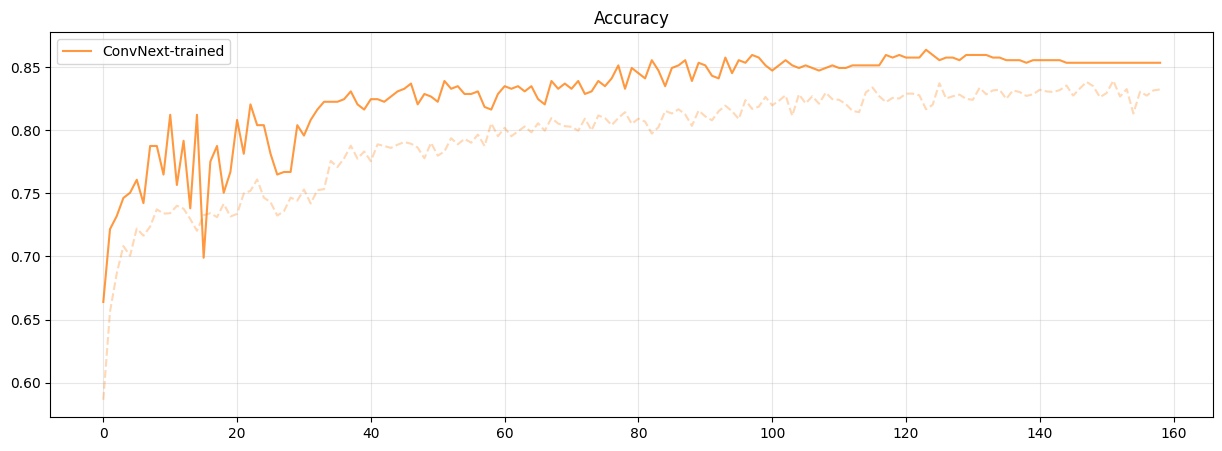

In [ ]:
# Plot the re-trained convNext training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='ConvNext-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='ConvNext-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
model.save('ConvNeXtBase-kerascv')

## Fine Tuning
Training also the backbone network. We already did transfer learning (train the new classification head only), now we ought to unfreeze the backbone layers (a few of them) and train the entire netrwork.



In [ ]:
model = tfk.models.load_model('ConvNeXtBase-kerascv')

In [ ]:
# Re-load the model after transfer learning
model.get_layer('convnext_base').trainable = True
model.summary()

Model: "convnext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550    
                                                                 
 dropout_4 (Dropout)         (None, 550)               0  

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 170
for i, layer in enumerate(model.get_layer('convnext_base').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_3 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_36 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_37 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_po

In [ ]:
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought
    y = y_train,
    batch_size = 16,
    epochs = 400,
    class_weight=class_weights,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
                 tf.keras.callbacks.ReduceLROnPlateau()]
).history

Epoch 1/400
243/243 [==============================] - 85s 150ms/step - loss: 0.5957 - accuracy: 0.7451 - val_loss: 0.5276 - val_accuracy: 0.8186 - lr: 3.0000e-04
Epoch 2/400
243/243 [==============================] - 28s 116ms/step - loss: 0.5332 - accuracy: 0.7763 - val_loss: 0.3753 - val_accuracy: 0.8454 - lr: 3.0000e-04
Epoch 3/400
243/243 [==============================] - 27s 110ms/step - loss: 0.4671 - accuracy: 0.8108 - val_loss: 0.3979 - val_accuracy: 0.8371 - lr: 3.0000e-04
Epoch 4/400
243/243 [==============================] - 28s 114ms/step - loss: 0.4227 - accuracy: 0.8389 - val_loss: 0.3854 - val_accuracy: 0.8557 - lr: 3.0000e-04
Epoch 5/400
243/243 [==============================] - 30s 125ms/step - loss: 0.3901 - accuracy: 0.8580 - val_loss: 0.3664 - val_accuracy: 0.8742 - lr: 3.0000e-04
Epoch 6/400
243/243 [==============================] - 27s 111ms/step - loss: 0.3580 - accuracy: 0.8657 - val_loss: 0.3908 - val_accuracy: 0.8454 - lr: 3.0000e-04
Epoch 7/400
243/243 [=

In [ ]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8907


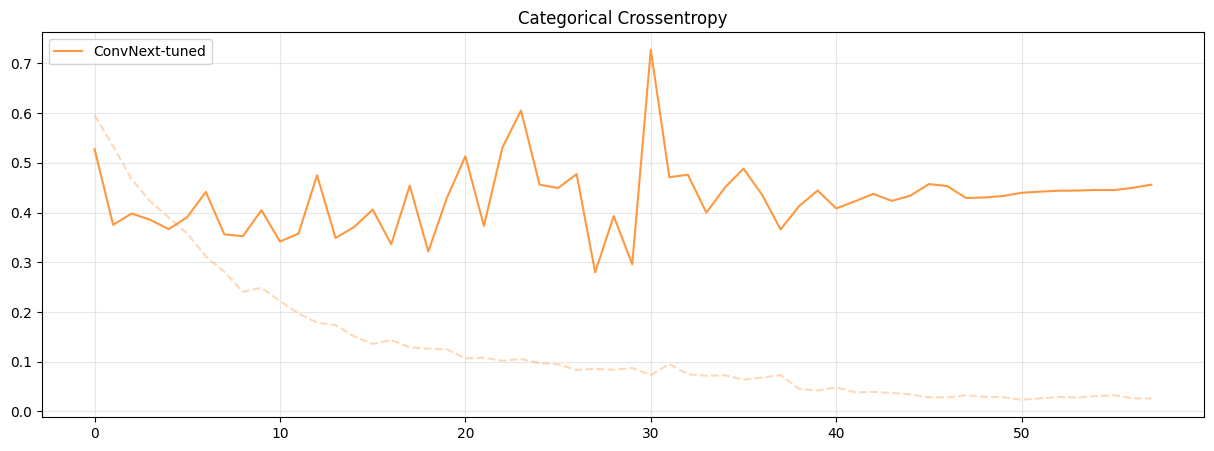

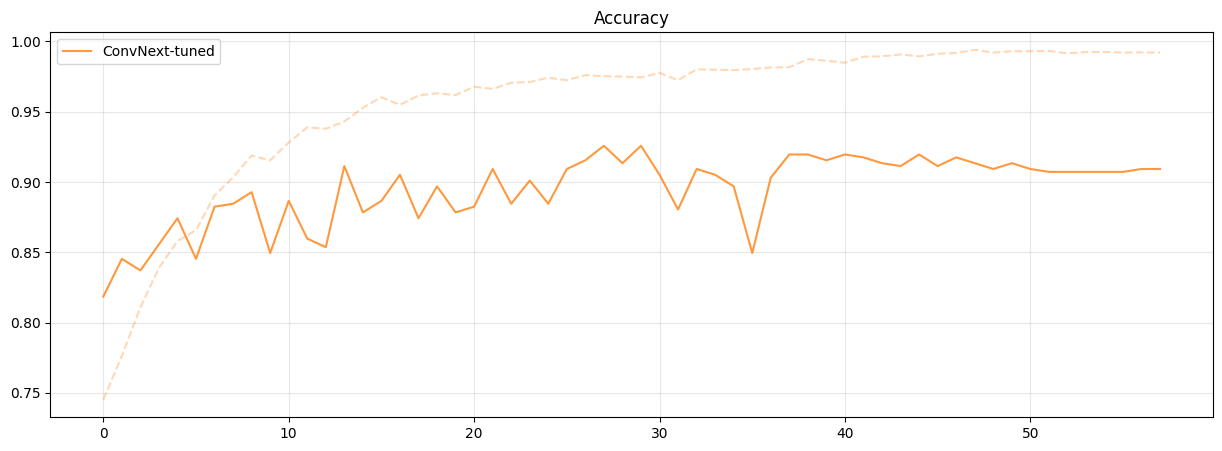

In [ ]:
# Plot the training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='ConvNext-tuned', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='ConvNext-tuned', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
model.save("ConvNeXtBase-kerascv-tuned")

### Test on your own data

Predictions Shape: (485, 2)
Accuracy: 0.8907
Precision: 0.8852
Recall: 0.8786
F1: 0.8817


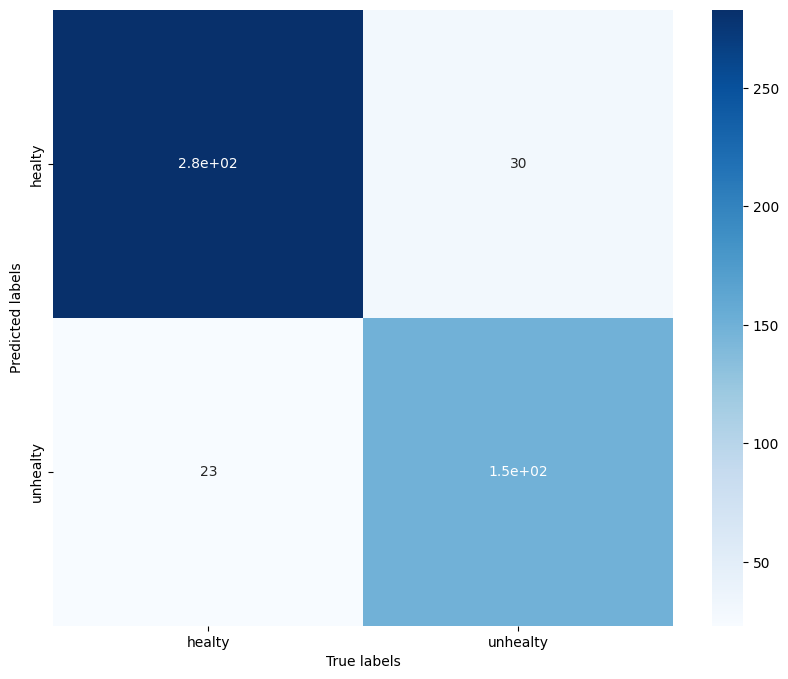

In [ ]:
model.reset_states()

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healty','unhealty')), yticklabels=list(('healty','unhealty')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()